In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Select the GPU index
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import time
import warnings
from math import sqrt
from PIL import Image
import torchvision.transforms as T
from torch.optim.lr_scheduler import _LRScheduler
import pandas as pd
import scipy.io
import math
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
from sklearn.decomposition import IncrementalPCA
from tqdm import tqdm

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Data Loader

In [2]:
num_H = 64

In [3]:
class DeepVerseChallengeLoaderTaskOne(Dataset):
    def __init__(self, csv_path, out_image_size=(256, 256)): 
        self.table = pd.read_csv(csv_path)
        self.dataset_folder = os.path.dirname(csv_path)
        self.position = self.table[['x', 'y']].to_numpy()

        self.images = self.table[['cam_left', 'cam_mid', 'cam_right']].to_numpy()
        self.out_image_size = out_image_size
        self.transform = T.Compose([T.PILToTensor(), T.Resize(size=self.out_image_size)])
        self.out_image_size = out_image_size
        
    def __len__(self):
        return len(self.table)
    
    def __getitem__(self, idx):
        P = torch.from_numpy(self.position[idx])

        radar_data_path = os.path.join(self.dataset_folder, self.table.loc[idx, 'radar'])
        R = torch.from_numpy(scipy.io.loadmat(radar_data_path)['ra'])

        I = [self.transform(Image.open(self.images[idx, i])) for i in range(3)]

        ch_data_path = os.path.join(self.dataset_folder, self.table.loc[idx, 'channel'])
        H = torch.from_numpy(scipy.io.loadmat(ch_data_path)['channel'])

        if num_H == 1:
            return (P,R,*I),H[:,0,0] 
        elif num_H == 64:
            return (P,R,*I), H
        else:
            return (P,R,*I), H[:,:num_H,:num_H]

### Utils

Function to calculate model parameters

In [4]:
def cal_model_parameters(model):
    total_param  = []
    for p1 in model.parameters():
        total_param.append(int(p1.numel()))
    return sum(total_param)

Function to preprocess CSI data (Complex numbers)

In [5]:
def CSI_reshape(y, csi_std=2.8117975e-06, target_std=1.0):
    y = torch.abs(y)
    y=(y/csi_std)*target_std
    return y

Preprocessing images

In [6]:
def normalize_image(image):
    # Convert image to float tensor
    image = image.float()
    # Normalize the image
    image /= 255.0
    # ImageNet mean values # ImageNet standard deviation values
    trans=T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) 
    image=trans(image)
    return image

In [7]:
def left_coordinates_batch(x_cor, y_cor):
    y_pix = torch.zeros_like(x_cor)
    x_pix = torch.zeros_like(y_cor)

    condition1 = y_cor < -4
    condition2 = (y_cor >= -4) & (y_cor < -1)
    condition3 = (y_cor >= -1) & (y_cor < 1)
    condition4 = (y_cor >= 1) & (y_cor < 4)
    condition5 = y_cor >= 4

    y_pix[condition1] = 100 + (250 - 100) * ((x_cor[condition1] - 80) / (125 - 80))
    y_pix[condition2] = 100 + (250 - 100) * ((x_cor[condition2] - 80) / (125 - 80))
    y_pix[condition3] = 100 + (250 - 100) * ((x_cor[condition3] - 80) / (125 - 80))
    y_pix[condition4] = 100 + (210 - 100) * ((x_cor[condition4] - 80) / (125 - 80))
    y_pix[condition5] = 100 + (190 - 100) * ((x_cor[condition5] - 80) / (125 - 80))

    x_pix[condition1] = (y_pix[condition1] - 30) / 1.35
    x_pix[condition2] = (y_pix[condition2] - 45) / 0.85
    x_pix[condition3] = (y_pix[condition3] - 55) / 0.70
    x_pix[condition4] = (y_pix[condition4] - 65) / 0.60
    x_pix[condition5] = (y_pix[condition5] - 65) / 0.5
    return x_pix, y_pix

In [8]:
def center_coordinates_batch(x_cor, y_cor):
    x_pix = torch.zeros_like(x_cor)
    y_pix = torch.zeros_like(y_cor)

    condition = y_cor < 0
    x_pix[condition] = 256 * ((x_cor[condition] - 119) / (139 - 119))
    x_pix[~condition] = 256 * ((x_cor[~condition] - 112) / (146 - 113))
    
    y_pix = 175 + (100 - 175) * ((y_cor - (-7)) / ((7) - (-7)))
    return x_pix, y_pix

In [9]:
def right_coordinates_batch(x_cor, y_cor):
    y_pix = torch.zeros_like(x_cor)
    x_pix = torch.zeros_like(y_cor)

    condition1 = y_cor < -4
    condition2 = (y_cor >= -4) & (y_cor < -1)
    condition3 = (y_cor >= -1) & (y_cor < 1)
    condition4 = (y_cor >= 1) & (y_cor < 4)
    condition5 = y_cor >= 4

    y_pix[condition1] = 250 + (100 - 250) * ((x_cor[condition1] - 125) / (200 - 125))
    y_pix[condition2] = 250 + (100 - 250) * ((x_cor[condition2] - 125) / (200 - 125))
    y_pix[condition3] = 250 + (100 - 250) * ((x_cor[condition3] - 125) / (200 - 125))
    y_pix[condition4] = 210 + (100 - 210) * ((x_cor[condition4] - 125) / (200 - 125))
    y_pix[condition5] = 190 + (100 - 190) * ((x_cor[condition5] - 125) / (200 - 125))

    x_pix[condition1] = -(y_pix[condition1] - 370) / 1.25
    x_pix[condition2] = -(y_pix[condition2] - 285) / 0.87
    x_pix[condition3] = -(y_pix[condition3] - 250) / 0.73
    x_pix[condition4] = -(y_pix[condition4] - 210) / 0.55
    x_pix[condition5] = -(y_pix[condition5] - 190) / 0.45
    return x_pix, y_pix

In [10]:
def center_image_batch(images, center_x, center_y, output_size, bounded=False):
    batch_size = images.size(0)
    
    if bounded == 'left':
        top = torch.clamp(center_y - output_size[0] // 2, 0, None)
        left = torch.clamp(center_x - output_size[1] // 2, 0, None)
    elif bounded == 'right':
        bottom = center_y + output_size[0] // 2
        right = torch.clamp(center_x + output_size[1] // 2, None, 250)
        top = torch.clamp(bottom - output_size[0], 0, None)
        left = right - output_size[1]
    else:
        top = center_y - output_size[0] // 2
        left = center_x - output_size[1] // 2

    resize_transform = transforms.Resize((output_size))
    cropped_images = [TF.crop(image, int(top[i].item()), int(left[i].item()), output_size[0], output_size[1]) 
                        for i, image in enumerate(images)]
    cropped_images = torch.stack([resize_transform(image) for image in cropped_images])
    return cropped_images

In [11]:
def process_imgs(gps, img_1, img_2, img_3, crop_size = (150,150)):
    x_cor = gps[:,0]
    y_cor = gps[:,1]

    x_pix,y_pix = left_coordinates_batch(x_cor, y_cor)
    img_1 = center_image_batch(img_1, x_pix.to(torch.int), y_pix.to(torch.int), crop_size, 'left')

    x_pix,y_pix = center_coordinates_batch(x_cor, y_cor)
    img_2 = center_image_batch(img_2, x_pix.to(torch.int), y_pix.to(torch.int), crop_size)

    x_pix,y_pix = right_coordinates_batch(x_cor, y_cor)
    img_3 = center_image_batch(img_3, x_pix.to(torch.int), y_pix.to(torch.int), crop_size, 'right')

    return img_1, img_2, img_3

Scheduler

In [12]:
class WarmUpCosineAnnealingLR(_LRScheduler):
    def __init__(self, optimizer, T_max, T_warmup, eta_min=0, last_epoch=-1):
        self.T_max = T_max
        self.T_warmup = T_warmup
        self.eta_min = eta_min
        super(WarmUpCosineAnnealingLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.T_warmup:
            return [base_lr * self.last_epoch / self.T_warmup for base_lr in self.base_lrs]
        else:
            k = 1 + math.cos(math.pi * (self.last_epoch - self.T_warmup) / (self.T_max - self.T_warmup))
            return [self.eta_min + (base_lr - self.eta_min) * k / 2 for base_lr in self.base_lrs]

### Data Processing Layers

In [13]:
class ConvBN(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, groups=1):
        if not isinstance(kernel_size, int):
            padding = [(i - 1) // 2 for i in kernel_size]
        else:
            padding = (kernel_size - 1) // 2
        super(ConvBN, self).__init__(OrderedDict([
            ('conv', nn.Conv2d(in_planes, out_planes, kernel_size, stride,
                               padding=padding, groups=groups, bias=False)),
            ('bn', nn.BatchNorm2d(out_planes))
        ]))

GPS Data Processing Layer

In [14]:
class gpsdata(nn.Module):
    def __init__(self):
        super().__init__()
        self.gps_fc = nn.Linear(2, 16)
        self.gps_relu = nn.ReLU()

    def forward(self, gps):  
        gps = gps.to(torch.float32)

        x, y = gps[:,0], gps[:,1]
        x_normd = (x - torch.min(x)) / (torch.max(x) - torch.min(x))
        y_normd = (y - torch.min(y)) / (torch.max(y) - torch.min(y))
        gps_normd = torch.stack([x_normd,y_normd],dim=1)

        gps_out = self.gps_fc(gps_normd)  
        gps_out = self.gps_relu(gps_out)
        return gps_out

Radar Data Processing Layer

In [15]:
class radardata(nn.Module):
    
    def __init__(self):
        super(radardata, self).__init__()
        self.dropout = nn.Dropout(p=0.5)
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3, stride=2, padding=1)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 1, kernel_size=3, stride=2, padding=1)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.lr1=nn.LeakyReLU(negative_slope=0.3, inplace=True)
        self.encoder_fc = nn.Linear(256,16)
                
    def forward(self, x):
        x=x.view(-1,1,512,128)
        x = (x - 5.1838e-06) / (28.0494 - 5.1838e-06)
        out = self.pool1(self.dropout(self.conv1(x)))
        out = self.pool2(self.dropout(self.conv2(out))).view(x.size(0), -1)
        out = self.dropout(self.encoder_fc(out))
        out = self.lr1(out)
        return out 

Camera Data Processing Layers

In [16]:
class cameradata(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=3, stride=2, padding=1)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 1, kernel_size=3, stride=2, padding=1)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.lr1=nn.LeakyReLU(negative_slope=0.3, inplace=True)
        self.encoder = nn.Linear(1*81,16)
        self.dropout = nn.Dropout(0.5)

    def forward(self, cam):  
        cam = normalize_image(cam).to(torch.float32)
        out = self.pool1(self.dropout(self.conv1(cam)))
        out = self.pool2(self.dropout(self.conv2(out)))
        out = self.lr1(out).view(-1,1*81)
        out = self.dropout(self.encoder(out))
        return out

### Models

In [17]:
class task1decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.gp = gpsdata()
        self.rd = radardata()
        self.lc = cameradata()
        self.cc = cameradata()
        self.rc = cameradata()

        if int(num_H/2)*int(num_H/2) > 32:
            self.linear = nn.Linear(16*5, int(num_H/2)*int(num_H/2))
            self.output_fc = nn.Linear(int(num_H/2)*int(num_H/2), num_H*num_H)
            self.output_relu = nn.ReLU()
        else:
            self.linear = nn.Linear(16*5, 32)
            self.output_fc = nn.Linear(32, num_H*num_H)
            self.output_relu = nn.ReLU()
        
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self,gps,radar,left_cam,center_cam,right_cam,onoffdict):
        bs = gps.size(0)
        
        if onoffdict['GPS']:
             gps_out = self.gp(gps)
        else:
             gps_out = torch.zeros(bs, 16).to(device)
        
        if onoffdict['RADAR']:
            radar_out = self.rd(radar)
        else:
            radar_out = torch.zeros(bs, 16).to(device)
        
        if onoffdict['CAMERAS']:
            left_cam, center_cam, right_cam = process_imgs(gps, left_cam, center_cam, right_cam, crop_size = (150,150))
            lc_out = self.lc(left_cam)
            cc_out = self.cc(center_cam)
            rc_out = self.rc(right_cam)
        else:
            lc_out = torch.zeros(bs, 16).to(device)
            cc_out = torch.zeros(bs, 16).to(device)
            rc_out = torch.zeros(bs, 16).to(device)

        combined = torch.cat((gps_out, radar_out, lc_out, cc_out, rc_out), dim=1)
        
        output = self.linear(combined)
        output = self.output_relu(output)
        output = self.output_fc(output)
        output = self.output_relu(output)
        output = output.view(output.size(0), 1, num_H, num_H)

        return output

### Parameters

In [18]:
onoffdict= {'GPS': False, 'CAMERAS': False, 'RADAR': False}

lr=0.004
num_epochs=100
patience=15
batch_size=64

weight_path=f'models1/task1/gps{onoffdict["GPS"]}_cam{onoffdict["CAMERAS"]}_rad{onoffdict["RADAR"]}/'
if not os.path.exists(weight_path):
    os.makedirs(weight_path)

train_dataset = DeepVerseChallengeLoaderTaskOne(csv_path = r'./dataset_train.csv')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=5) 
test_dataset = DeepVerseChallengeLoaderTaskOne(csv_path = r'./dataset_validation.csv')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=5)

model=task1decoder()
print(f'Number of parameters in Task1 Decoder: {cal_model_parameters(model)}')

Number of parameters in Task1 Decoder: 4290224


In [19]:
len(train_dataset)

11000

In [20]:
len(test_dataset)

2500

### Training & Testing Model

In [19]:
def task1_training(onoffdict,verbose=False):
    model=task1decoder()
    criterion= nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9, weight_decay=1e-5)
    scheduler = WarmUpCosineAnnealingLR(optimizer=optimizer,
                                                T_max=num_epochs * len(train_loader),
                                                T_warmup=5 * len(train_loader),
                                                eta_min=1e-6)

    model=model.to(device)
    if not os.path.exists("models"):
        os.makedirs("models")

    start_time = time.time()
    num_train_batches=len(train_loader)
    num_test_batches=len(test_loader)
    train_losses = []
    val_losses = []
    patience_counter = 0
    best_val_loss = float('inf')

    for i in range(num_epochs):
        loss1 = 0
        epoch_time = time.time() 
        model.train()

        for b, (X_train, y_train) in enumerate(train_loader):  

            y_train=y_train.to(device)
            y_pred=model(X_train[0].to(device),X_train[1].to(device),X_train[2].to(device),X_train[3].to(device),X_train[4].to(device), onoffdict)
            y_train_reshaped=CSI_reshape(y_train)

            loss = criterion(y_pred, y_train_reshaped) 
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            loss1=loss1+loss
            
        train_loss=loss1/num_train_batches  
        train_losses.append(train_loss.item())

        model.eval()
        with torch.no_grad():
            loss1=0
            for b, (X_test, y_test) in enumerate(test_loader):

                y_test=y_test.to(device)
                y_pred=model(X_test[0].to(device),X_test[1].to(device),X_test[2].to(device),X_test[3].to(device),X_test[4].to(device), onoffdict)
                y_test_reshaped=CSI_reshape(y_test)

                loss = criterion(y_pred, y_test_reshaped) 
                loss1=loss1+loss   

            val_loss=loss1/num_test_batches  
            val_losses.append(val_loss.item())
        
        if verbose: print(f'epoch:{i+1}/{num_epochs} average TL:{train_loss.item():10.8f} average VL:{val_loss.item():10.8f} epoch time:{time.time() - epoch_time:.0f} seconds, lr:{optimizer.param_groups[0]["lr"]:.2e}')               

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model, weight_path + "task1Decoder.pth")
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            if verbose: print(f'Validation loss did not decrease for {patience} epochs. Stopping training.')
            break  
                    
    print(f'\nDuration: {time.time() - start_time:.0f} seconds')     
    return train_losses, val_losses, best_val_loss    

In [20]:
def display_results(train_losses, val_losses, best_val_loss, onoffdict):
    h_list = torch.tensor([])
    for b, (x,h) in enumerate(test_loader):
        h = CSI_reshape(h)
        h_list = torch.cat([h_list,h])
    target_loss = torch.mean((torch.abs(h_list) - torch.mean(torch.abs(h_list))) ** 2)

    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    active_data_components = [component for component, status in onoffdict.items() if status]
    if active_data_components:
        data_used = " ".join(active_data_components)
    else:
        data_used = "No "
    plt.title('Loss over Time with ' + data_used + ' Data')
    plt.show()
    print(f'Loss from Taking Average: {target_loss:.4f}')
    print(f'Best Validation Loss: {best_val_loss:.4f}')
    
    improvement = (target_loss.item() - best_val_loss.item()) / target_loss.item() * 100
    print(f'Percentage Improvement Achieved: {improvement:.4f}%')
    return improvement

### Multiple Runs

epoch:1/100 average TL:0.83104759 average VL:0.67743766 epoch time:503 seconds, lr:8.00e-04
epoch:2/100 average TL:0.55347031 average VL:0.64984477 epoch time:496 seconds, lr:1.60e-03
epoch:3/100 average TL:0.56010044 average VL:0.54255557 epoch time:479 seconds, lr:2.40e-03
epoch:4/100 average TL:0.53534591 average VL:0.53882796 epoch time:481 seconds, lr:3.20e-03
epoch:5/100 average TL:0.51585317 average VL:0.53310508 epoch time:501 seconds, lr:4.00e-03
epoch:6/100 average TL:0.52062172 average VL:0.53854710 epoch time:492 seconds, lr:4.00e-03
epoch:7/100 average TL:0.49845105 average VL:0.63064528 epoch time:499 seconds, lr:4.00e-03
epoch:8/100 average TL:0.50414371 average VL:0.50102013 epoch time:489 seconds, lr:3.99e-03
epoch:9/100 average TL:0.49373084 average VL:0.51685566 epoch time:500 seconds, lr:3.98e-03
epoch:10/100 average TL:0.47355404 average VL:0.54894692 epoch time:453 seconds, lr:3.97e-03
epoch:11/100 average TL:0.48906335 average VL:0.53933132 epoch time:423 seconds

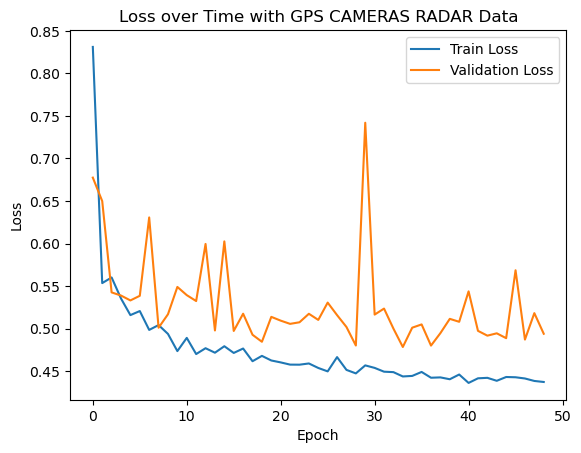

Loss from Taking Average: 1.1158
Best Validation Loss: 0.4784
Percentage Improvement Achieved: 57.1262%


In [29]:
onoffdict = {'GPS': True, 'CAMERAS': True, 'RADAR': True}
weight_path=f'models1/task1/gps{onoffdict["GPS"]}_cam{onoffdict["CAMERAS"]}_rad{onoffdict["RADAR"]}/'
if not os.path.exists(weight_path):
    os.makedirs(weight_path)
train_losses, val_losses, best_val_loss = task1_training(onoffdict,verbose=True)
improvement = display_results(train_losses, val_losses, best_val_loss, onoffdict)

epoch:1/100 average TL:0.92655253 average VL:0.85021466 epoch time:452 seconds, lr:8.00e-04
epoch:2/100 average TL:0.58243930 average VL:0.91210538 epoch time:445 seconds, lr:1.60e-03
epoch:3/100 average TL:0.55084223 average VL:0.57419729 epoch time:452 seconds, lr:2.40e-03
epoch:4/100 average TL:0.53282726 average VL:0.57585430 epoch time:452 seconds, lr:3.20e-03
epoch:5/100 average TL:0.50924021 average VL:0.51503265 epoch time:453 seconds, lr:4.00e-03
epoch:6/100 average TL:0.52368569 average VL:0.87060374 epoch time:450 seconds, lr:4.00e-03
epoch:7/100 average TL:0.51318604 average VL:0.55879587 epoch time:447 seconds, lr:4.00e-03
epoch:8/100 average TL:0.49686942 average VL:0.52369535 epoch time:441 seconds, lr:3.99e-03
epoch:9/100 average TL:0.49311674 average VL:0.51834625 epoch time:448 seconds, lr:3.98e-03
epoch:10/100 average TL:0.50077099 average VL:0.49982920 epoch time:468 seconds, lr:3.97e-03
epoch:11/100 average TL:0.47745350 average VL:0.51095372 epoch time:471 seconds

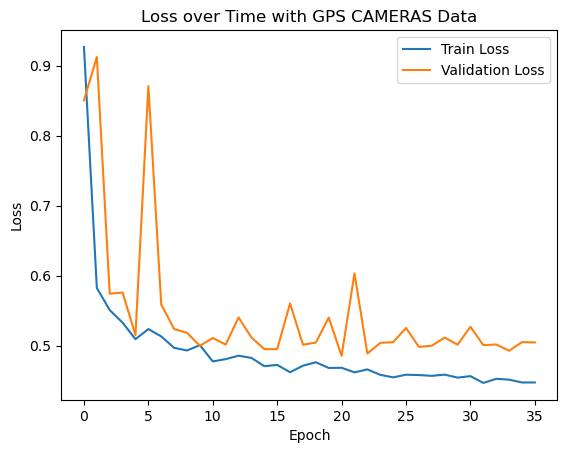

Loss from Taking Average: 1.1158
Best Validation Loss: 0.4855
Percentage Improvement Achieved: 56.4910%


In [22]:
onoffdict = {'GPS': True, 'CAMERAS': True, 'RADAR': False}
weight_path=f'models1/task1/gps{onoffdict["GPS"]}_cam{onoffdict["CAMERAS"]}_rad{onoffdict["RADAR"]}/'
if not os.path.exists(weight_path):
    os.makedirs(weight_path)
train_losses, val_losses, best_val_loss = task1_training(onoffdict,verbose=True)
improvement = display_results(train_losses, val_losses, best_val_loss, onoffdict)

epoch:1/100 average TL:1.12335646 average VL:1.06372392 epoch time:397 seconds, lr:8.00e-04
epoch:2/100 average TL:0.88172364 average VL:0.84214908 epoch time:402 seconds, lr:1.60e-03
epoch:3/100 average TL:0.65954220 average VL:0.69573295 epoch time:425 seconds, lr:2.40e-03
epoch:4/100 average TL:0.57929617 average VL:0.61192513 epoch time:461 seconds, lr:3.20e-03
epoch:5/100 average TL:0.55091530 average VL:0.64631873 epoch time:441 seconds, lr:4.00e-03
epoch:6/100 average TL:0.53181881 average VL:0.58732855 epoch time:460 seconds, lr:4.00e-03
epoch:7/100 average TL:0.52242416 average VL:0.56019562 epoch time:436 seconds, lr:4.00e-03
epoch:8/100 average TL:0.51330954 average VL:0.55020344 epoch time:458 seconds, lr:3.99e-03
epoch:9/100 average TL:0.51707047 average VL:0.55594558 epoch time:464 seconds, lr:3.98e-03
epoch:10/100 average TL:0.51172447 average VL:0.55830127 epoch time:468 seconds, lr:3.97e-03
epoch:11/100 average TL:0.50279069 average VL:0.60189492 epoch time:474 seconds

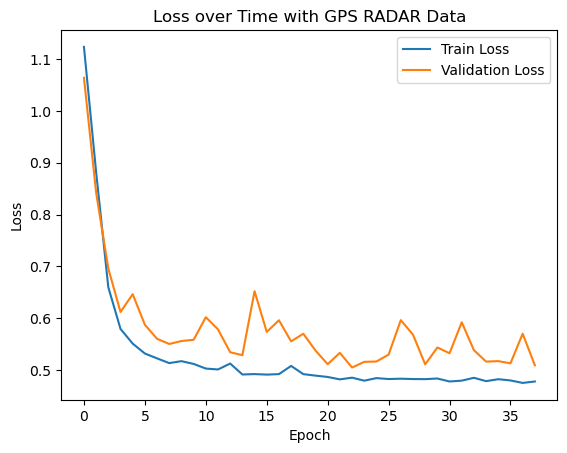

Loss from Taking Average: 1.1158
Best Validation Loss: 0.5048
Percentage Improvement Achieved: 54.7590%


In [23]:
onoffdict = {'GPS': True, 'CAMERAS': False, 'RADAR': True}
weight_path=f'models1/task1/gps{onoffdict["GPS"]}_cam{onoffdict["CAMERAS"]}_rad{onoffdict["RADAR"]}/'
if not os.path.exists(weight_path):
    os.makedirs(weight_path)
train_losses, val_losses, best_val_loss = task1_training(onoffdict,verbose=True)
improvement = display_results(train_losses, val_losses, best_val_loss, onoffdict)

epoch:1/100 average TL:1.26522040 average VL:1.10449600 epoch time:341 seconds, lr:8.00e-04
epoch:2/100 average TL:0.87263322 average VL:0.84788591 epoch time:333 seconds, lr:1.60e-03
epoch:3/100 average TL:0.68040669 average VL:0.74247903 epoch time:335 seconds, lr:2.40e-03
epoch:4/100 average TL:0.60033756 average VL:0.63326252 epoch time:333 seconds, lr:3.20e-03
epoch:5/100 average TL:0.55518341 average VL:0.72888476 epoch time:342 seconds, lr:4.00e-03
epoch:6/100 average TL:0.53377402 average VL:0.59794492 epoch time:347 seconds, lr:4.00e-03
epoch:7/100 average TL:0.51954973 average VL:0.63101834 epoch time:336 seconds, lr:4.00e-03
epoch:8/100 average TL:0.53088832 average VL:0.62114686 epoch time:339 seconds, lr:3.99e-03
epoch:9/100 average TL:0.50790381 average VL:0.55698109 epoch time:343 seconds, lr:3.98e-03
epoch:10/100 average TL:0.51209104 average VL:0.63280076 epoch time:339 seconds, lr:3.97e-03
epoch:11/100 average TL:0.50034952 average VL:0.54962271 epoch time:340 seconds

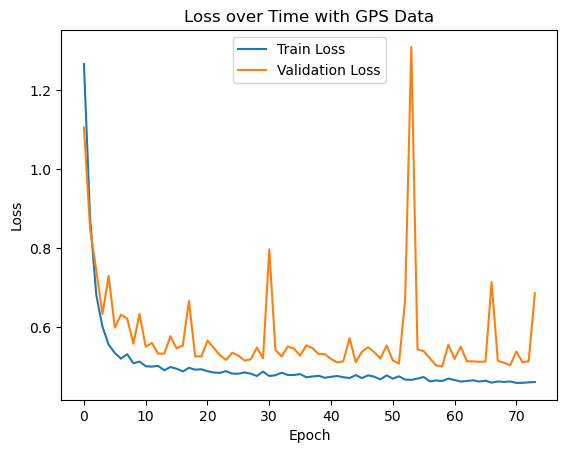

Loss from Taking Average: 1.1158
Best Validation Loss: 0.4999
Percentage Improvement Achieved: 55.1975%


In [24]:
onoffdict = {'GPS': True, 'CAMERAS': False, 'RADAR': False}
weight_path=f'models1/task1/gps{onoffdict["GPS"]}_cam{onoffdict["CAMERAS"]}_rad{onoffdict["RADAR"]}/'
if not os.path.exists(weight_path):
    os.makedirs(weight_path)
train_losses, val_losses, best_val_loss = task1_training(onoffdict,verbose=True)
improvement = display_results(train_losses, val_losses, best_val_loss, onoffdict)

epoch:1/100 average TL:0.99610847 average VL:1.01141357 epoch time:338 seconds, lr:8.00e-04
epoch:2/100 average TL:0.61842859 average VL:0.69967425 epoch time:337 seconds, lr:1.60e-03
epoch:3/100 average TL:0.58043414 average VL:0.60333675 epoch time:333 seconds, lr:2.40e-03
epoch:4/100 average TL:0.57541692 average VL:0.68155235 epoch time:341 seconds, lr:3.20e-03
epoch:5/100 average TL:0.56669992 average VL:0.56600583 epoch time:339 seconds, lr:4.00e-03
epoch:6/100 average TL:0.53634399 average VL:0.54354876 epoch time:390 seconds, lr:4.00e-03
epoch:7/100 average TL:0.54569477 average VL:0.59965354 epoch time:389 seconds, lr:4.00e-03
epoch:8/100 average TL:0.52908099 average VL:0.59510416 epoch time:376 seconds, lr:3.99e-03
epoch:9/100 average TL:0.52763808 average VL:0.54141992 epoch time:372 seconds, lr:3.98e-03
epoch:10/100 average TL:0.52799708 average VL:0.53488690 epoch time:379 seconds, lr:3.97e-03
epoch:11/100 average TL:0.51576728 average VL:0.53364688 epoch time:380 seconds

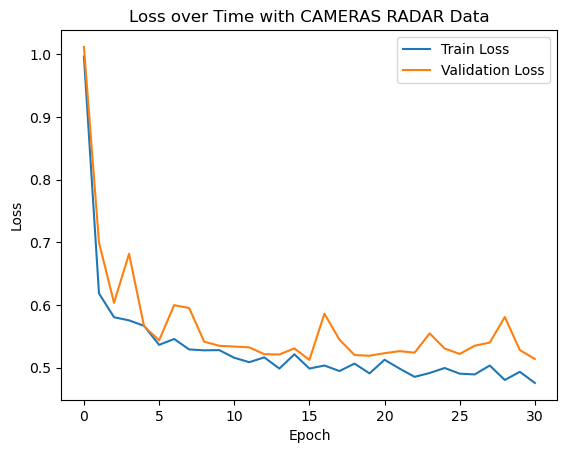

Loss from Taking Average: 1.1158
Best Validation Loss: 0.5124
Percentage Improvement Achieved: 54.0785%


In [25]:
onoffdict = {'GPS': False, 'CAMERAS': True, 'RADAR': True}
weight_path=f'models1/task1/gps{onoffdict["GPS"]}_cam{onoffdict["CAMERAS"]}_rad{onoffdict["RADAR"]}/'
if not os.path.exists(weight_path):
    os.makedirs(weight_path)
train_losses, val_losses, best_val_loss = task1_training(onoffdict,verbose=True)
improvement = display_results(train_losses, val_losses, best_val_loss, onoffdict)

epoch:1/100 average TL:0.85093379 average VL:0.84323627 epoch time:444 seconds, lr:8.00e-04
epoch:2/100 average TL:0.59127676 average VL:0.66371989 epoch time:450 seconds, lr:1.60e-03
epoch:3/100 average TL:0.55774337 average VL:0.64323300 epoch time:449 seconds, lr:2.40e-03
epoch:4/100 average TL:0.60899830 average VL:0.60506117 epoch time:433 seconds, lr:3.20e-03
epoch:5/100 average TL:0.56444037 average VL:0.58134061 epoch time:418 seconds, lr:4.00e-03
epoch:6/100 average TL:0.55160809 average VL:0.57617664 epoch time:437 seconds, lr:4.00e-03
epoch:7/100 average TL:0.55126506 average VL:0.54040515 epoch time:453 seconds, lr:4.00e-03
epoch:8/100 average TL:0.54783708 average VL:0.54854554 epoch time:451 seconds, lr:3.99e-03
epoch:9/100 average TL:0.53569180 average VL:0.56182283 epoch time:429 seconds, lr:3.98e-03
epoch:10/100 average TL:0.51973897 average VL:0.54726392 epoch time:423 seconds, lr:3.97e-03
epoch:11/100 average TL:0.51652718 average VL:0.51779538 epoch time:458 seconds

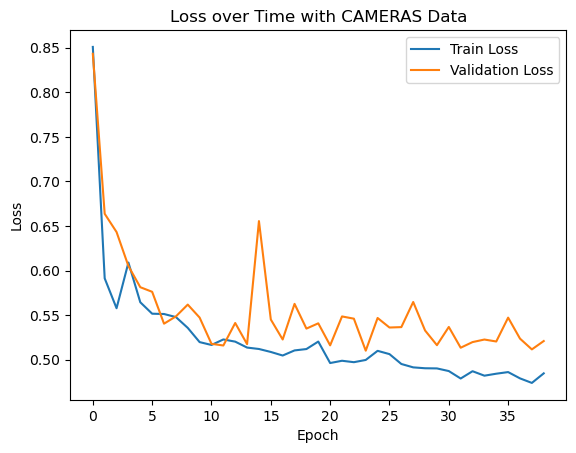

Loss from Taking Average: 1.1158
Best Validation Loss: 0.5101
Percentage Improvement Achieved: 54.2813%


In [26]:
onoffdict = {'GPS': False, 'CAMERAS': True, 'RADAR': False}
weight_path=f'models1/task1/gps{onoffdict["GPS"]}_cam{onoffdict["CAMERAS"]}_rad{onoffdict["RADAR"]}/'
if not os.path.exists(weight_path):
    os.makedirs(weight_path)
train_losses, val_losses, best_val_loss = task1_training(onoffdict,verbose=True)
improvement = display_results(train_losses, val_losses, best_val_loss, onoffdict)

epoch:1/100 average TL:1.15154731 average VL:1.12386084 epoch time:385 seconds, lr:8.00e-04
epoch:2/100 average TL:1.01175284 average VL:1.15193570 epoch time:387 seconds, lr:1.60e-03
epoch:3/100 average TL:1.00681627 average VL:1.09586430 epoch time:410 seconds, lr:2.40e-03
epoch:4/100 average TL:1.00656843 average VL:1.10000026 epoch time:439 seconds, lr:3.20e-03
epoch:5/100 average TL:1.00716257 average VL:1.10889554 epoch time:438 seconds, lr:4.00e-03
epoch:6/100 average TL:1.00506616 average VL:1.09697652 epoch time:424 seconds, lr:4.00e-03
epoch:7/100 average TL:1.00327623 average VL:1.10725725 epoch time:443 seconds, lr:4.00e-03
epoch:8/100 average TL:0.99208337 average VL:1.06370342 epoch time:425 seconds, lr:3.99e-03
epoch:9/100 average TL:0.98125875 average VL:1.05804336 epoch time:440 seconds, lr:3.98e-03
epoch:10/100 average TL:0.97688001 average VL:1.06015599 epoch time:414 seconds, lr:3.97e-03
epoch:11/100 average TL:0.97711307 average VL:1.05466568 epoch time:402 seconds

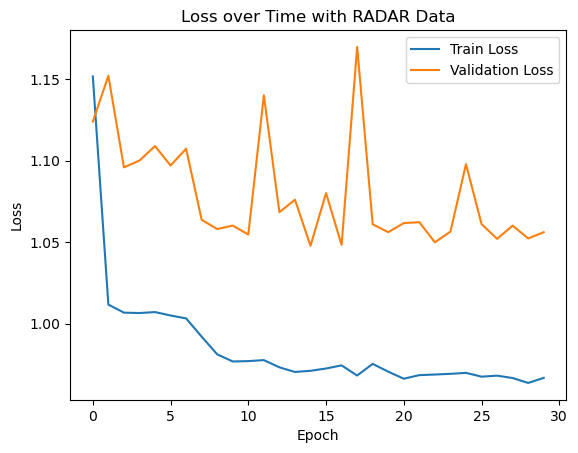

Loss from Taking Average: 1.1158
Best Validation Loss: 1.0478
Percentage Improvement Achieved: 6.0966%


In [27]:
onoffdict = {'GPS': False, 'CAMERAS': False, 'RADAR': True}
weight_path=f'models1/task1/gps{onoffdict["GPS"]}_cam{onoffdict["CAMERAS"]}_rad{onoffdict["RADAR"]}/'
if not os.path.exists(weight_path):
    os.makedirs(weight_path)
train_losses, val_losses, best_val_loss = task1_training(onoffdict,verbose=True)
improvement = display_results(train_losses, val_losses, best_val_loss, onoffdict)

epoch:1/100 average TL:1.32375920 average VL:1.11800134 epoch time:469 seconds, lr:8.00e-04
epoch:2/100 average TL:1.00557911 average VL:1.09896791 epoch time:452 seconds, lr:1.60e-03
epoch:3/100 average TL:1.00478888 average VL:1.10111809 epoch time:457 seconds, lr:2.40e-03
epoch:4/100 average TL:1.00627089 average VL:1.11306965 epoch time:477 seconds, lr:3.20e-03
epoch:5/100 average TL:1.00647557 average VL:1.09758723 epoch time:482 seconds, lr:4.00e-03
epoch:6/100 average TL:1.00655544 average VL:1.14342213 epoch time:467 seconds, lr:4.00e-03
epoch:7/100 average TL:1.00381970 average VL:1.10877919 epoch time:463 seconds, lr:4.00e-03
epoch:8/100 average TL:1.00652444 average VL:1.14195871 epoch time:455 seconds, lr:3.99e-03
epoch:9/100 average TL:1.00634909 average VL:1.09617436 epoch time:456 seconds, lr:3.98e-03
epoch:10/100 average TL:1.00608742 average VL:1.10710740 epoch time:480 seconds, lr:3.97e-03
epoch:11/100 average TL:1.00555861 average VL:1.10036850 epoch time:471 seconds

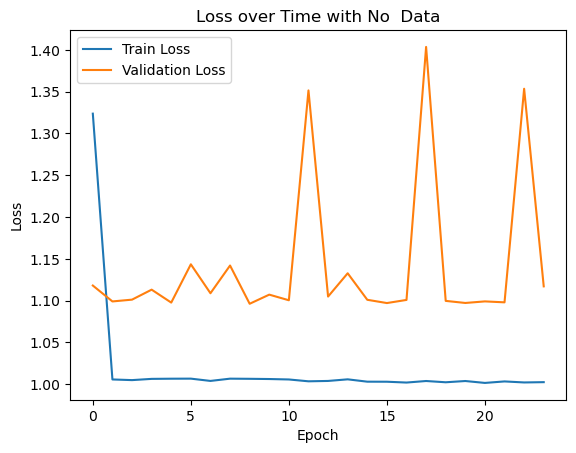

Loss from Taking Average: 1.1158
Best Validation Loss: 1.0962
Percentage Improvement Achieved: 1.7572%


In [28]:
onoffdict = {'GPS': False, 'CAMERAS': False, 'RADAR': False}
weight_path=f'models1/task1/gps{onoffdict["GPS"]}_cam{onoffdict["CAMERAS"]}_rad{onoffdict["RADAR"]}/'
if not os.path.exists(weight_path):
    os.makedirs(weight_path)
train_losses, val_losses, best_val_loss = task1_training(onoffdict,verbose=True)
improvement = display_results(train_losses, val_losses, best_val_loss, onoffdict)